Download weights and place them **INSIDE YOUR BASE GOOGLE DRIVER FOLDER** (MAKE AN ACCOUNT IF IT HAS A 404 ERROR, ACCEPT THE LICENSE AGREEMENT IF IT SAYS YOU ARE UNAUTHORIZED): https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/blob/main/sd-v1-4.ckpt --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------              Alternatively, download them here! https://drive.google.com/file/d/1kPURA5ErV9ohu872LEOIrsiElpoGb9ww/view                                                                            
Original collab by u/Najbox, modified by u/cR_Spitfire or Thicc Birb#1468 on Discord

In [ ]:
#@title Let's get things set up
!nvidia-smi
#@title Setup
!git clone https://github.com/CompVis/stable-diffusion.git
!pip install omegaconf einops pytorch-lightning transformers kornia -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers -e git+https://github.com/openai/CLIP.git@main#egg=clip


from IPython.display import clear_output 
clear_output()


#@title Copy model from drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/stable-diffusion/models/ldm/stable-diffusion-v1/
!cp -r /content/drive/MyDrive/sd-v1-4.ckpt /content/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt

#@title Reload
import os
os._exit(00)

#after executing this cell notebook will reload, this is normal, just proceed executing cells

Mounted at /content/drive


# The environment has been reloaded, don't fret about the error! It's intentional. Last setup below.

In [1]:
#@title Last setup!
%cd stable-diffusion
!mkdir ImageC
from IPython.display import clear_output 
clear_output()
#@title Importing libraries and defining functions
"""make variations of input image"""

import os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
from pytorch_lightning import seed_everything

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config_path = "configs/stable-diffusion/v1-inference.yaml", ckpt = "models/ldm/stable-diffusion-v1/model.ckpt", verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]

    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


def image2image(prompt, plms = True, outdir = "/content/output", n_samples = 3, n_rows = 0, skip_save = False, skip_grid = False, ddim_steps = 50, from_file = None, fixed_code = False, strength = 0.75, init_img = "/content/stable-diffusion/assets/stable-samples/img2img/sketch-mountains-input.jpg", C = 4, H = 512, W = 512, f = 8, precision = "full", n_iter = 2, seed = 1610684295, scale = 7.5, ddim_eta = 0):


    if plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    if not from_file:
        prompt = prompt
        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) - 1

    assert os.path.isfile(init_img)
    init_image = load_img(init_img).to(device)
    init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        # encode (scaled latent)
                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        # decode it
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=uc,)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        if not skip_save:
                            for x_sample in x_samples:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count:05}.png"))
                                base_count += 1
                        all_samples.append(x_samples)

                if not skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                toc = time.time()

    print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
          f" \nEnjoy.")
    return grid_count

#@title Loading model
model = load_model_from_config()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

torch.cuda.empty_cache()

from IPython.display import clear_output 
clear_output()
from google.colab import output
output.enable_custom_widget_manager()
from google.colab import output
output.disable_custom_widget_manager()

# All configuration is done, from here use following cells to generate your images

In [123]:
#@title <---  Upload Image
import os
from google.colab import files

uploaded = files.upload()           # Use colab upload dialog.
uploaded = list(uploaded.keys())    # Get uploaded filenames.
assert len(uploaded) == 1           # Make sure only uploaded one file.
os.rename(uploaded[0], 'image.png') 

import cv2
import numpy as np

def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

#@markdown Tesla P100 Max = 704 and Tesla T4 Max = 640
maxsize = 704 #@param ["512", "640", "704"] {type:"raw"}

v_img = cv2.imread('/content/stable-diffusion/image.png') # vertical image
scaled_v_img = resizeAndPad(v_img, (maxsize,maxsize), 127)

h_img = cv2.imread('/content/stable-diffusion/image.png') # horizontal image
scaled_h_img = resizeAndPad(h_img, (maxsize,maxsize), 127)

sq_img = cv2.imread('/content/stable-diffusion/image.png') # square image
scaled_sq_img = resizeAndPad(sq_img, (maxsize,maxsize), 127)


Horizontal_Picture = scaled_h_img
Vertical_Picture = scaled_v_img
Crop_Picture = scaled_sq_img


val = Horizontal_Picture

cv2.imwrite('/content/stable-diffusion/ImageC/image_1.png', val)

Saving IMG_20220826_002356.jpg to IMG_20220826_002356.jpg


True

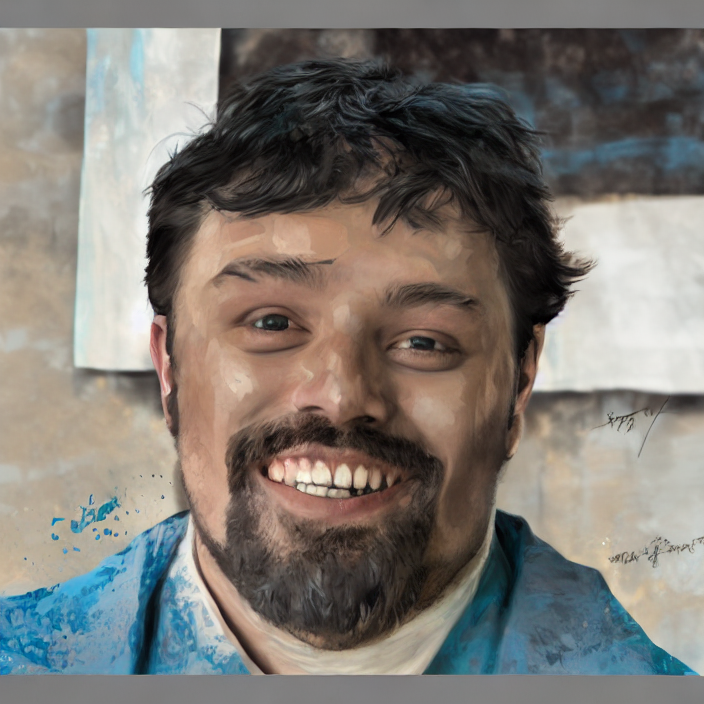

In [139]:
#@title <----- Apply settings and generate

#@markdown Don't use short and simple prompts, complex prompts will give better results
prompt = "art portrait of a fantasy knight" #@param {type:"string"}
StartImage = "/content/stable-diffusion/ImageC/image_1.png"
#@markdown The higher it is, the more the image will be modified [0.1 to 1]
Strength = 0.572 #@param {type:"slider", min:0, max:1, step:0.001}

#@markdown The more steps you use, the better image you get, but I don't recommend using more than 150 steps
steps = 20 #@param {type:"slider", min:1, max:150, step:1}


Height = 512
Width = 512

import random

#@markdown Setting
Samples = 1 #@param ["1", "2", "3", "4"] {type:"raw"}
Iteration = 1 #@param ["1", "2", "3", "4"] {type:"raw"}
Seed = random.randrange(9999999999)
CFGScale = 10 #@param {type:"slider", min:-2, max:20, step:0.1}


sampler = "ddim"

if sampler == "plms":
    plms = True
else:
    plms = False

#@title <---- Start generator
grid_count = image2image(prompt = prompt, init_img = StartImage, strength = Strength, ddim_steps = steps, plms = plms, H = Height, W = Width, n_samples = Samples, n_iter = Iteration, seed = Seed, scale = CFGScale,)
from IPython.display import clear_output 
clear_output()

#@title Result
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(f"/content/output/grid-{grid_count-1:04}.png")

cv2_imshow(img)    

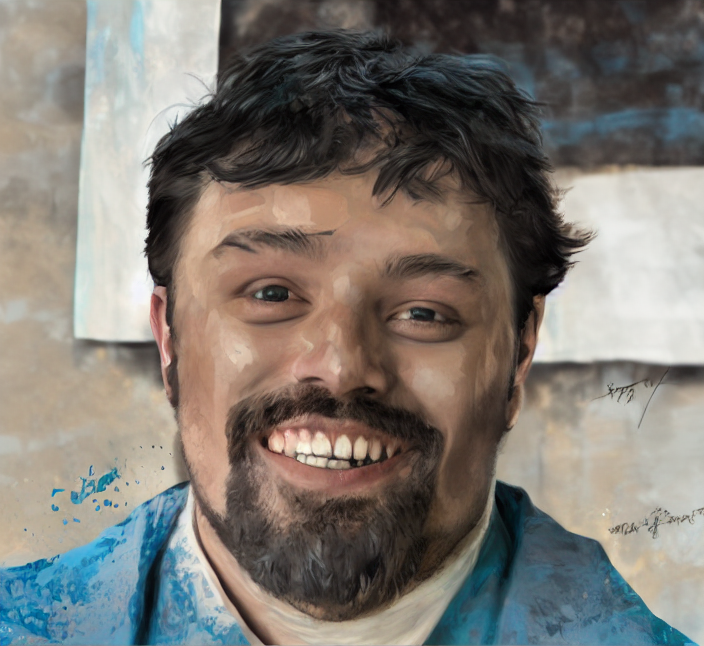

In [140]:
#@title Gray edge remover (optional)
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new("RGB", im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im.convert("RGB"), bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

im = Image.open(f"/content/output/grid-{grid_count-1:04}.png")
im = trim(im)
im


In [38]:
#@title Recycle Result
import os

#@markdown This prepares the result to be generated, with a "Strength" value not too high, it allows to deeply modify the image while preserving the coherence of the starting image.

old_file_name = f"/content/output/grid-{grid_count-1:04}.png"
new_file_name = "/content/stable-diffusion/ImageC/image_1.png"

os.rename(old_file_name, new_file_name)

print("The result is ready to be recycled")

The result is ready to be recycled
